# On Analyzing Real World Time Series for Forecasting Stock Data - Shanghai Composite Index

- PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023

## TODOs

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../framework_for_time_series_data/tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis with Forecasts

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-04", "2020-01-30"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = '000001.SS'
stock_of_interest = stocks[stock_symbol]
type(stock_of_interest), stock_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_series = stock_of_interest.get_series()
stock_series

array([3243.76000977, 3282.17895508, 3254.21508789, ..., 3052.13989258,
       3060.75488281, 2976.52807617])

In [6]:
stock_df = stock_of_interest.get_as_df()
stock_df

,Close
Date,
2010-01-04,3243.760010
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
...,...
2020-01-17,3075.496094
2020-01-20,3095.787109
2020-01-21,3052.139893


### Plot Raw Data

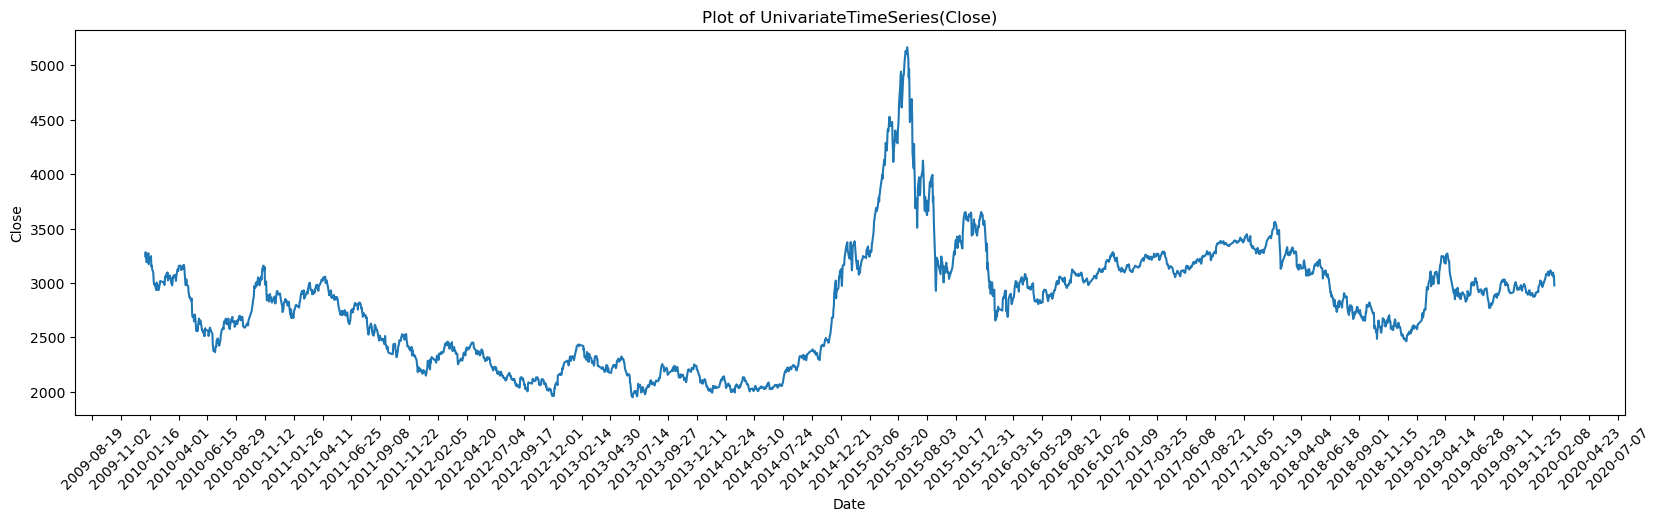

In [7]:
stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [8]:
stock_of_interest.get_statistics()

,Close
count,2443.000000
mean,2801.352097
std,529.728447
min,1950.011963
25%,2345.647461
50%,2859.918945
75%,3128.335083
max,5166.350098


In [9]:
stock_of_interest.range_skewness_kurtosis()

{'Range': Close    3216.338135
 dtype: float64,
 'Skewness': Close    0.748415
 dtype: float64,
 'Kurtosis': Close    1.530622
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [10]:
stock_of_interest.stationarity_test(stock_df)

ADF Statistic: -2.208837
p-value: 0.203054 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [11]:
stock_of_interest.independence_test(stock_df)

BDS Statistic: 146.655997
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the differenced TS is independent and i.i.d.


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

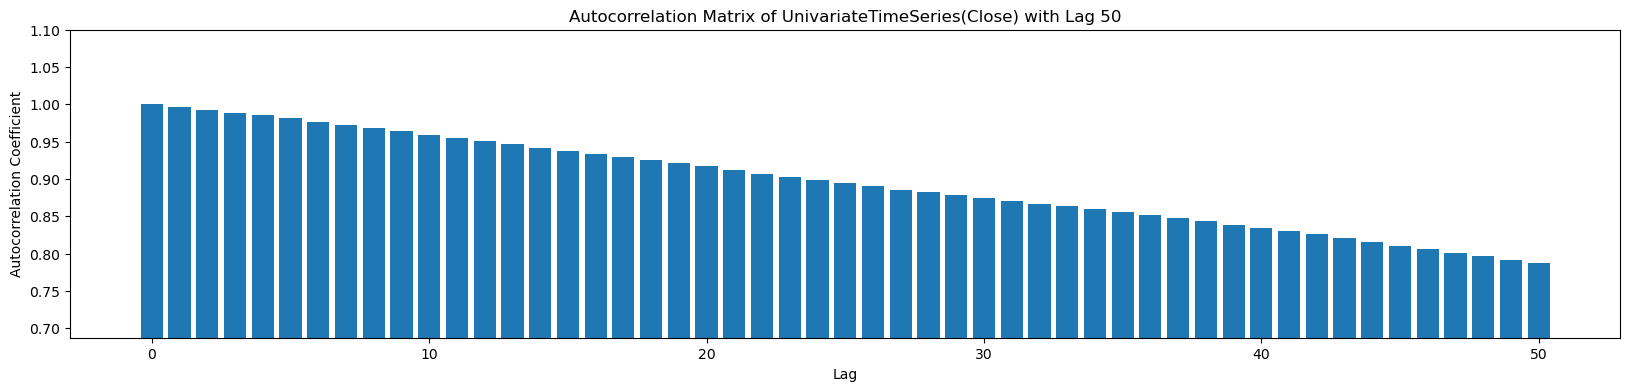

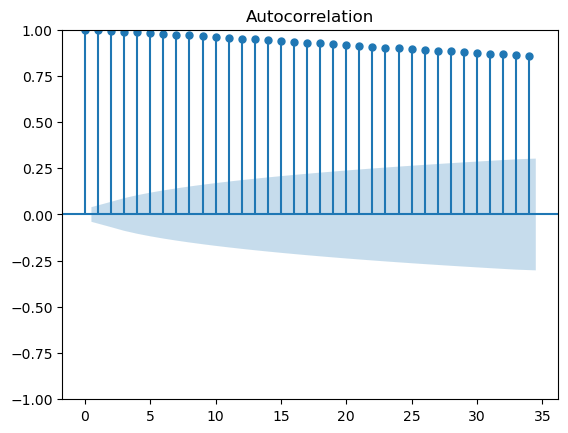

In [12]:
stock_of_interest.plot_autocorrelation(50)

- What is the above telling us?

In [13]:
# stock_of_interest.plot_partial_autocorrelation(35)

- What is the above telling us?

### Get Returns Data

In [14]:
len(stock_of_interest.get_series()), stock_of_interest.get_series()

(2443,
 array([3243.76000977, 3282.17895508, 3254.21508789, ..., 3052.13989258,
        3060.75488281, 2976.52807617]))

In [15]:
stock_returns = stock_of_interest.data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [16]:
# threshold_acorrs_for_returns = stock_returns.autocorrelation_with_threshold()
# len(threshold_acorrs_for_returns), threshold_acorrs_for_returns

- What if we adjust the threshold?

In [17]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2010-01-05,0.011844
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
...,...
2020-01-17,0.000460
2020-01-20,0.006598
2020-01-21,-0.014099


### Plot Returns

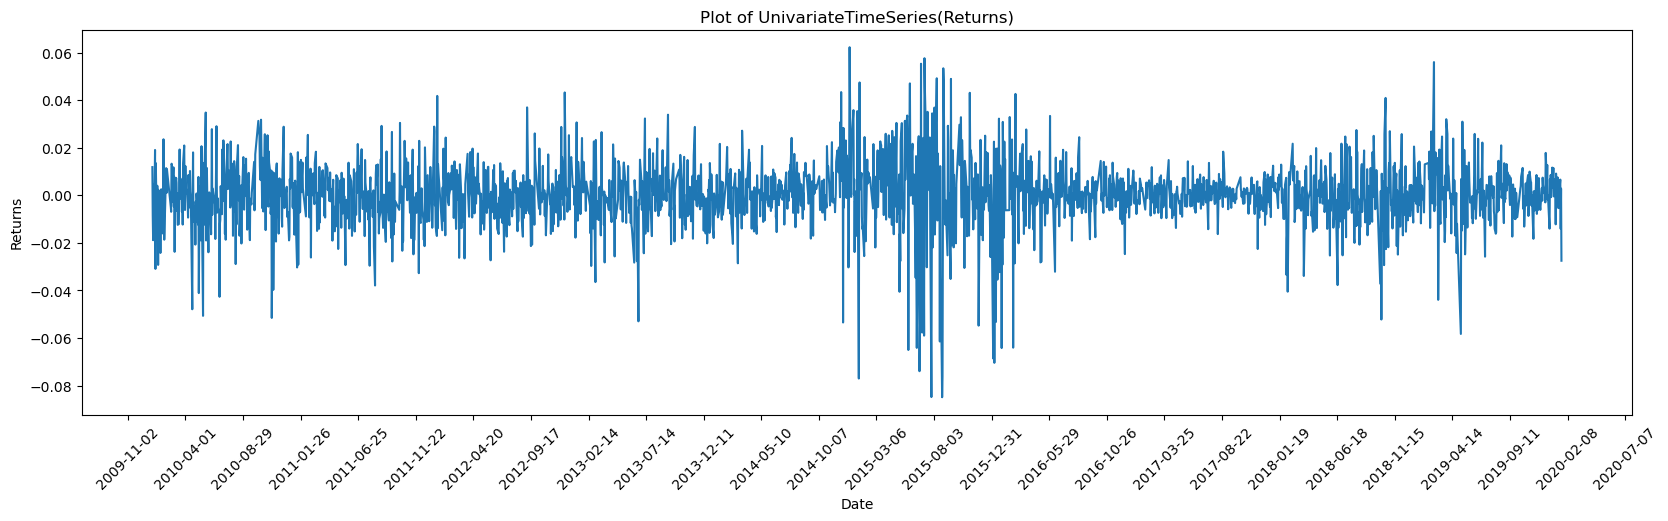

In [18]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant although there are a few wide spread mean values between ~2014-10-07 to 2016-05-29 and ~2017-08-22 to 2019-04-14.

### Get Descriptive Statistics of Returns Data

In [19]:
stock_returns.get_statistics()

,Returns
count,2442.000000
mean,0.000057
std,0.013553
min,-0.084909
25%,-0.005829
50%,0.000499
75%,0.006320
max,0.062260


In [20]:
stock_returns.range_skewness_kurtosis()

{'Range': Returns    0.147169
 dtype: float64,
 'Skewness': Returns   -0.738703
 dtype: float64,
 'Kurtosis': Returns    5.648276
 dtype: float64}

### Check Stationarity of Returns Data

In [21]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -9.620772
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [22]:
stock_returns.get_series()

array([ 0.01184395, -0.00851991, -0.01887989, ..., -0.01409891,
        0.00282261, -0.02751831])

In [23]:
stock_returns.independence_test(stock_returns_df)

BDS Statistic: 8.055382
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the differenced TS is independent and i.i.d.


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

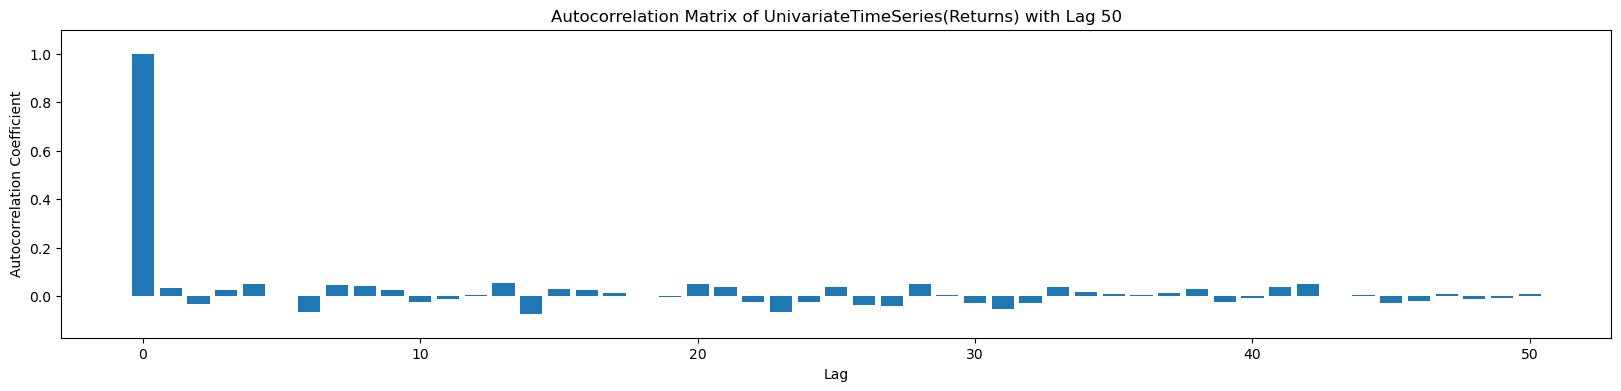

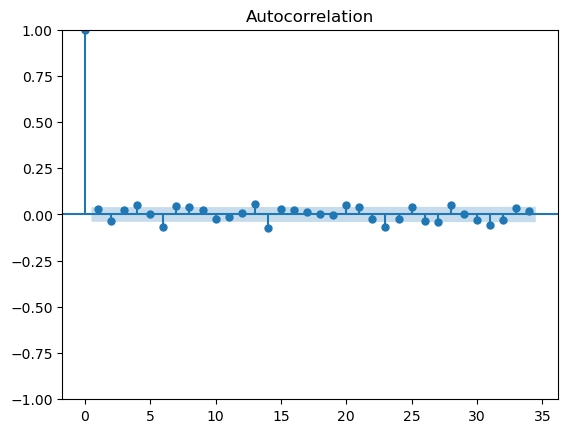

In [24]:
stock_returns.plot_autocorrelation(50)

- Lag exponentially decays at 1, thus use lag 1 for `MA(q)` as they have in the PAPER.

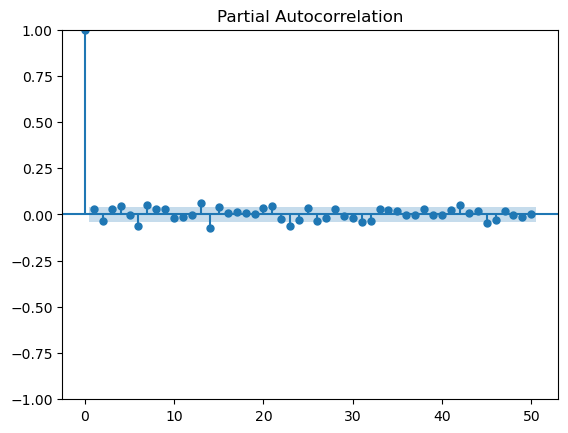

In [25]:
stock_returns.plot_partial_autocorrelation(50)

- Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

### Train Test Split Returns Data

- 80% train and 20% test

In [26]:
forecasting_step = 1
X = stock_returns.get_historical_data(forecasting_step)
X = X['Returns'].values
X

array([ 0.01184395, -0.00851991, -0.01887989, ...,  0.00659764,
       -0.01409891,  0.00282261])

In [27]:
y = stock_returns.get_true_label_data(forecasting_step)
y = y['Returns'].values
y

array([-0.02751831])

In [28]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, test_size=0.2, shuffle=False)

In [29]:
import numpy as np
import pandas as pd
def convert_uts_sequence_to_sml_with_pd(uts_observations, prior_observations, forecasting_step):
    """Splits a given UTS into multiple input rows where each input row has a specified number of timestamps and the output is a single timestamp.
    
    Parameters:
    uts_observations -- 1D np array (of UTS data to transform to SML data with size  b rows/length x 1 dimension)
    prior_observations -- py int (of all observations before we get to where we want to start making the predictions)
    forecasting_step -- py int (of how far out to forecast, 1 only the next timestamp, 2 the next two timestamps, ... n the next n timestamps)
    
    Return:
    agg.values -- np array (of new sml data)
    """
    
    df = pd.DataFrame(uts_observations)
    cols = list()
    
    lag_col_names = []
    count_lag = 0
    
    # print("Input Univariate Time Series:")
    # print(uts_observations, "\nX of size", np.shape(uts_observations))
    # print()
    
    # input sequence (t-n, ... t-1)
    for prior_observation in range(prior_observations, 0, -1):
        # print("prior_observation: ", prior_observation)
        cols.append(df.shift(prior_observation))
        new_col_name = "t-" + str(prior_observation)
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecasting_step):
        cols.append(df.shift(-i))
        
        new_col_name = "t" 
        if forecasting_step == 1:
            # print(new_col_name)
            lag_col_names.append(new_col_name)
        
        else:
            if i == 0:
                lag_col_names.append(new_col_name)
            else:
                new_col_name = "t+" + str(i)
                # print(new_col_name)
                lag_col_names.append(new_col_name)
        
        # put it all together
        uts_sml_df = pd.concat(cols, axis=1) 
        uts_sml_df.columns=[lag_col_names]
        # drop rows with NaN values
        uts_sml_df.dropna(inplace=True)
    
    # print(uts_sml_df)
    print("Univariate Time Series as Supervised Machine Learning:")
    # colums to use to make prediction for last col
    
    # X_train = uts_sml_df.iloc[:, :prior_observations]
    # print("X_train: \n", X_train)
    
    # # last column
    # y_train = uts_sml_df.iloc[:, -forecasting_step:]
    # print("y_train: \n", y_train)
    return uts_sml_df

In [33]:
stock_returns.get_as_df()

# df = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10. 
1, 2, 3

,Returns
Date,
2010-01-05,0.011844
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
...,...
2020-01-17,0.000460
2020-01-20,0.006598
2020-01-21,-0.014099


In [30]:
reformatted_returns_df = convert_uts_sequence_to_sml_with_pd(stock_returns.get_series(), 1, forecasting_step)
reformatted_returns_df

Univariate Time Series as Supervised Machine Learning:


,t-1,t
1,0.011844,-0.008520
2,-0.008520,-0.018880
3,-0.018880,0.001009
4,0.001009,0.005242
5,0.005242,0.019054
...,...,...
2437,-0.005165,0.000460
2438,0.000460,0.006598
2439,0.006598,-0.014099
2440,-0.014099,0.002823


In [31]:
X = reformatted_returns_df['t-1']
X

,t-1
1,0.011844
2,-0.008520
3,-0.018880
4,0.001009
5,0.005242
...,...
2437,-0.005165
2438,0.000460
2439,0.006598
2440,-0.014099


In [32]:
y = reformatted_returns_df['t']
y

,t
1,-0.008520
2,-0.018880
3,0.001009
4,0.005242
5,0.019054
...,...
2437,0.000460
2438,0.006598
2439,-0.014099
2440,0.002823


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Initialize Autoregressive ARMA(p, q) Model

In [34]:
arma_class = ARMA()
arma_class

ARMA()

In [37]:
p = [1]
q = [1]
trained_arma_models = arma_class.train_arma_model(X_train, p, q)
trained_arma_models

ARMA( 1 0 1 )
                               SARIMAX Results                                
Dep. Variable:                    t-1   No. Observations:                 1952
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5577.508
Date:                Mon, 19 Feb 2024   AIC                         -11149.015
Time:                        17:33:05   BIC                         -11132.285
Sample:                             0   HQIC                        -11142.865
                               - 1952                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6155      0.155     -3.960      0.000      -0.920      -0.311
ma.L1          0.6575      0.148      4.431      0.000       0.367       0.948
sigma2         0.0002   3.19e-06     6

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
arma_predictions = arma_class.predict(trained_arma_models, len(X_train), X_train, y_train)
arma_predictions

ARMA( <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x1acbabf70> )


/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[1952     5.138784e-04
 1953    -3.163108e-04
 1954     1.947007e-04
 1955    -1.198453e-04
 1956     7.376914e-05
             ...      
 3899   -4.940656e-324
 3900    4.940656e-324
 3901   -4.940656e-324
 3902    4.940656e-324
 3903   -4.940656e-324
 Name: predicted_mean, Length: 1952, dtype: float64]

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Raw Data

In [42]:
EvaluationMetric.eval_mse(X_train, arma_predictions)
EvaluationMetric.eval_rmse(X_train, arma_predictions)
print()

Test MSE: 0.000
Test RMSE: 0.014



ValueError: x and y must have same first dimension, but have shapes (489,) and (1952,)

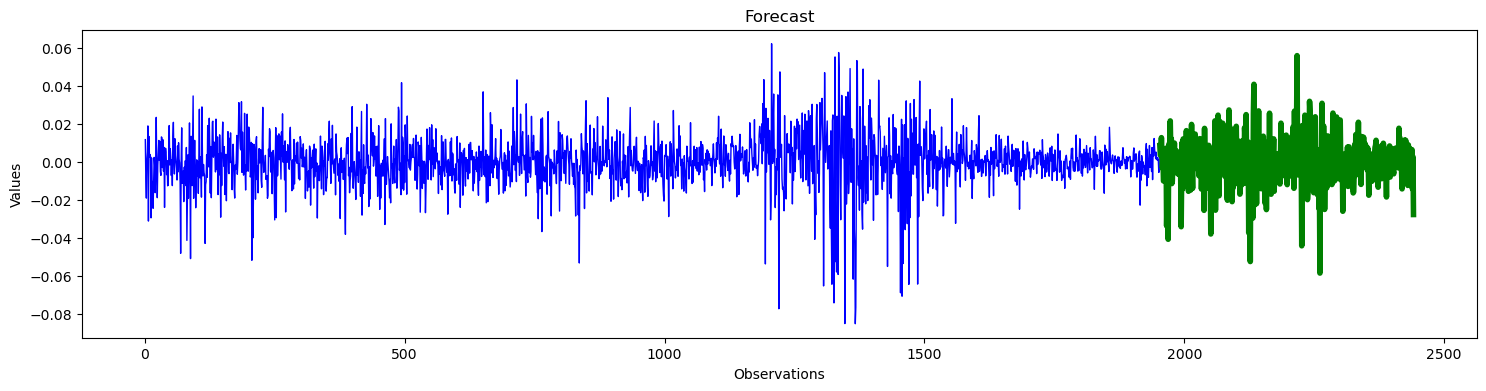

In [47]:
EvaluationMetric.plot_forecast(X_train, y_test, arma_predictions)

### Follow-up
- What can we determine from this?
    - 10 Day Forecast:
        - Actual Forecast (with the real prices): We'd want to buy on 2020-12-28 and sell on 2020-12-28.
        - Predicted Forecast (`AR` model): We'd want to by on 2020-12-18 and sell on 2020-12-21.
        - Predicted Forecast (`AR` model): We'd want to by on 2020-12-24 and sell on 2020-12-28.
- Can we do better? or Why might this be wrong?
    - We only consider AR. The data does NOT have multicollinearity [some of the lagged variables provide redundant information] bc we differenced to get the returns.
    - Our MSE and RMSE are lower compared to our `AR` when NOT differencing.
- What to consider?